In [22]:
import numpy as np
import pandas as pd

In [23]:
df = pd.read_csv('TempAarauData/order_113875_data.txt', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278588 entries, 0 to 278587
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   stn       278588 non-null  object
 1   time      278588 non-null  int64 
 2   tre200s0  278588 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.4+ MB


/var/folders/7w/25d_8rnd1w585vzs6fcbyhlw0000gn/T/ipykernel_3070/100937945.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('TempAarauData/order_113875_data.txt', sep=';')


In [24]:
df.head()

,stn,time,tre200s0
0,AGAAR,201804150840,12.8
1,AGAAR,201804150850,13.3
2,AGAAR,201804150900,14.4
3,AGAAR,201804150910,13.8
4,AGAAR,201804150920,13.7


In [25]:
df.tail()

,stn,time,tre200s0
278583,AGAAR,202308012310,13.9
278584,AGAAR,202308012320,13.8
278585,AGAAR,202308012330,13.6
278586,AGAAR,202308012340,14.1
278587,AGAAR,202308012350,13.8


In [26]:
# Extract the tre200s0 column from df
col = df['tre200s0']
# Remove missing values
col = col[col != "-"]
# Convert to float
col = col.astype(float)
# Convert to numpy array
values = col.to_numpy()
values = np.atleast_2d(values).T
# Calculate spectrum of values
spectrum = np.max(values) - np.min(values)

In [27]:
from src.kronecker import massaged_svd, compute_shapes, kronecker_decomposition
import numpy as np

rank = 4

# Calculate Kronecker
shape_a, shape_b = compute_shapes(values.shape)
u, s, vh = massaged_svd(values, shape_a)
a_mats, b_mats = kronecker_decomposition(u, s, vh, shape_a, shape_b, k=rank)

val_approx = np.zeros(values.shape)
ranks = np.zeros((rank, values.shape[0], values.shape[1]))
for k in range(rank):
    a_mat = a_mats[k]
    b_mat = b_mats[k]

    ranks[k] = np.kron(a_mat, b_mat)
    val_approx += ranks[k]

    rel_rmse = np.sqrt(np.mean((values - val_approx) ** 2)) / spectrum
    rel_me = np.mean(np.abs(values - val_approx)) / spectrum

    print(f'Rank {k + 1}:\tRMSE: {rel_rmse:.4f}\tME: {rel_me:.4f}')

Rank 1:	RMSE: 0.1486	ME: 0.1205
Rank 2:	RMSE: 0.0689	ME: 0.0531
Rank 3:	RMSE: 0.0000	ME: 0.0000
Rank 4:	RMSE: 0.0000	ME: 0.0000


In [28]:
values_sorted = np.sort(values, axis=0)

# Calculate Kronecker
u_sorted, s_sorted, vh_sorted = massaged_svd(values_sorted, shape_a)
a_mats_sorted, b_mats_sorted = kronecker_decomposition(u_sorted, s_sorted, vh_sorted, shape_a, shape_b, k=rank)

val_approx_sorted = np.zeros(values_sorted.shape)
ranks_sorted = np.zeros((rank, values_sorted.shape[0], values_sorted.shape[1]))
for k in range(rank):
    a_mat_sorted = a_mats_sorted[k]
    b_mat_sorted = b_mats_sorted[k]

    ranks_sorted[k] = np.kron(a_mat_sorted, b_mat_sorted)
    val_approx_sorted += ranks_sorted[k]

    rel_rmse_sorted = np.sqrt(np.mean((values_sorted - val_approx_sorted) ** 2)) / spectrum
    rel_me_sorted = np.mean(np.abs(values_sorted - val_approx_sorted)) / spectrum

    print(f'Rank {k + 1} (sorted):\tRMSE: {rel_rmse_sorted:.4f}\tME: {rel_me_sorted:.4f}')

Rank 1 (sorted):	RMSE: 0.0291	ME: 0.0185
Rank 2 (sorted):	RMSE: 0.0071	ME: 0.0041
Rank 3 (sorted):	RMSE: 0.0000	ME: 0.0000
Rank 4 (sorted):	RMSE: 0.0000	ME: 0.0000


In [29]:
values_shuffled = np.copy(values)
np.random.shuffle(values_shuffled)

# Calculate Kronecker
u_shuffled, s_shuffled, vh_shuffled = massaged_svd(values_shuffled, shape_a)
a_mats_shuffled, b_mats_shuffled = kronecker_decomposition(u_shuffled, s_shuffled, vh_shuffled, shape_a, shape_b,
                                                           k=rank)

val_approx_shuffled = np.zeros(values_shuffled.shape)
ranks_shuffled = np.zeros((rank, values_shuffled.shape[0], values_shuffled.shape[1]))
for k in range(rank):
    a_mat_shuffled = a_mats_shuffled[k]
    b_mat_shuffled = b_mats_shuffled[k]

    ranks_shuffled[k] = np.kron(a_mat_shuffled, b_mat_shuffled)
    val_approx_shuffled += ranks_shuffled[k]

    rel_rmse_shuffled = np.sqrt(np.mean((values_shuffled - val_approx_shuffled) ** 2)) / spectrum
    rel_me_shuffled = np.mean(np.abs(values_shuffled - val_approx_shuffled)) / spectrum

    print(f'Rank {k + 1} (shuffled):\tRMSE: {rel_rmse_shuffled:.4f}\tME: {rel_me_shuffled:.4f}')

Rank 1 (shuffled):	RMSE: 0.1417	ME: 0.1151
Rank 2 (shuffled):	RMSE: 0.1001	ME: 0.0763
Rank 3 (shuffled):	RMSE: 0.0000	ME: 0.0000
Rank 4 (shuffled):	RMSE: 0.0000	ME: 0.0000


In [30]:
print(f"original:")
%timeit np.sum(values)
for k in range(rank):
    print(f"krone(rank {k + 1}):")
    # %timeit np.sum([np.sum(a_mats[r]) * np.sum(b_mats[r]) for r in range(k + 1)])

original:
52.4 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
krone(rank 1):
krone(rank 2):
krone(rank 3):
krone(rank 4):


In [31]:
# SUM
sum_approx = 0
sum_approx_sorted = 0
sum_approx_shuffled = 0
for k in range(rank):
    sum_approx += np.sum(a_mats[k]) * np.sum(b_mats[k])
    sum_approx_sorted += np.sum(a_mats_sorted[k]) * np.sum(b_mats_sorted[k])
    sum_approx_shuffled += np.sum(a_mats_shuffled[k]) * np.sum(b_mats_shuffled[k])

    rel_error = np.abs(sum_approx - np.sum(values)) / spectrum
    rel_error_sorted = np.abs(sum_approx_sorted - np.sum(values)) / spectrum
    rel_error_shuffled = np.abs(sum_approx_shuffled - np.sum(values)) / spectrum

    print(
        f'Rank {k + 1}:\tRelative error: {rel_error:9.4f}\tRelative error sorted: {rel_error_sorted:9.4f}\tRelative error shuffled: {rel_error_shuffled:9.4f}')

Rank 1:	Relative error:   56.1242	Relative error sorted:  599.4107	Relative error shuffled:    0.0348
Rank 2:	Relative error:   88.3383	Relative error sorted:   23.8775	Relative error shuffled:    0.0049
Rank 3:	Relative error:    0.0000	Relative error sorted:    0.0000	Relative error shuffled:    0.0000
Rank 4:	Relative error:    0.0000	Relative error sorted:    0.0000	Relative error shuffled:    0.0000


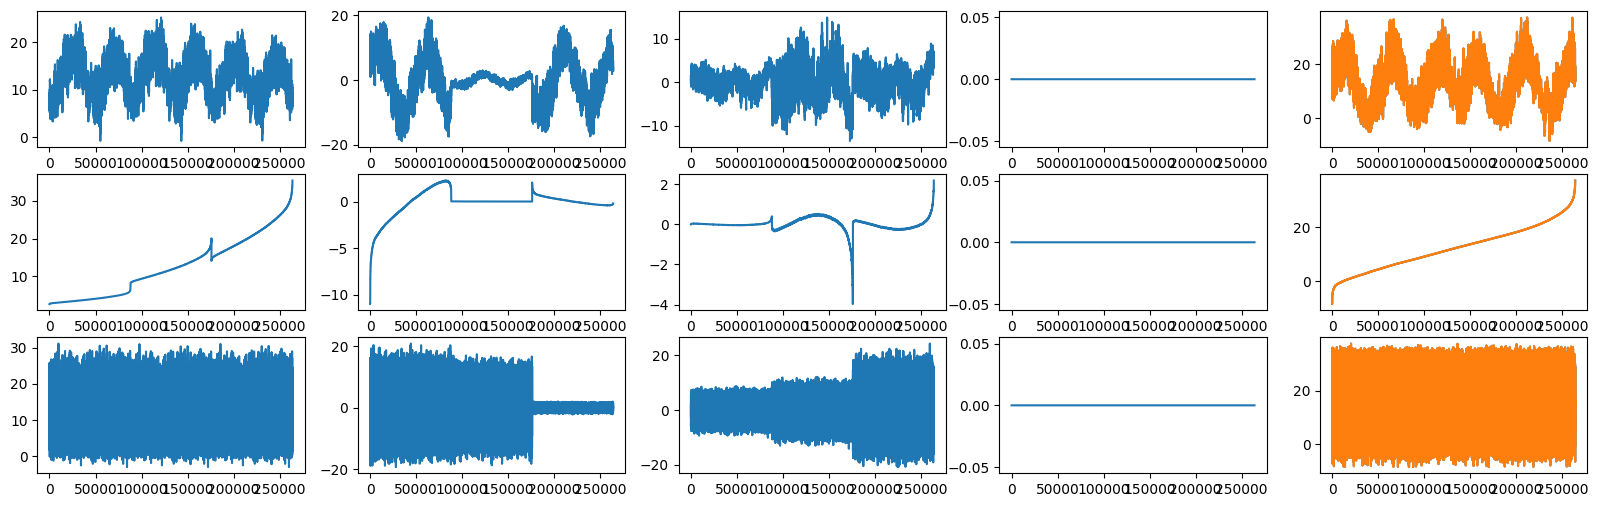

In [32]:
import matplotlib.pyplot as plt

# Plot
start = 0
stop = values.shape[0]
x = np.arange(start=start, stop=stop)

# Approximation
plt.figure(figsize=(20, 6))
for k in range(rank):
    ax1 = plt.subplot(3, rank + 1, k + 1)
    y1 = ranks[k, start:stop, 0]
    ax1.plot(x, y1)

    ax2 = plt.subplot(3, rank + 1, k + 1 + rank + 1)
    y2 = ranks_sorted[k, start:stop, 0]
    ax2.plot(x, y2)

    ax3 = plt.subplot(3, rank + 1, k + 1 + 2 * (rank + 1))
    y3 = ranks_shuffled[k, start:stop, 0]
    ax3.plot(x, y3)

# Original
ax1 = plt.subplot(3, rank + 1, rank + 1)
y1_approx = val_approx[start:stop, 0]
ax1.plot(x, y1_approx)
y1_orig = values[start:stop, 0]
ax1.plot(x, y1_orig)

ax2 = plt.subplot(3, rank + 1, rank + 1 + rank + 1)
y2_approx = val_approx_sorted[start:stop, 0]
ax2.plot(x, y2_approx)
y2_orig = values_sorted[start:stop, 0]
ax2.plot(x, y2_orig)

ax3 = plt.subplot(3, rank + 1, rank + 1 + 2 * (rank + 1))
y3_approx = val_approx_shuffled[start:stop, 0]
ax3.plot(x, y3_approx)
y3_orig = values_shuffled[start:stop, 0]
ax3.plot(x, y3_orig)
